In [47]:
from atlite.gis import ExclusionContainer
import atlite
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import rasterio.crs as crs
import cartopy.crs as ccrs
from shapely.geometry import MultiPolygon, Polygon
from atlite.gis import shape_availability
import rasterio
import xarray as xr
from pyproj import CRS
import seaborn as sns
import matplotlib.lines as mlines

In [26]:
os.chdir("C:\\Users\\alex-\\Documents\\TU Berlin\\EW_Mod\\EW_Mod_Paper")
url = "https://tubcloud.tu-berlin.de/s/RHZJrN8Dnfn26nr/download/NUTS_RG_10M_2021_4326.geojson"
nuts = gpd.read_file(url)
nuts = nuts.query("LEVL_CODE == 1")
nuts = nuts[nuts["CNTR_CODE"].isin(["DE"])]  # Filter for Germany)]  


C:\Users\alex-\AppData\Local\Temp\ipykernel_5160\3403731453.py:28: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
C:\Users\alex-\AppData\Local\Temp\ipykernel_5160\3403731453.py:55: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


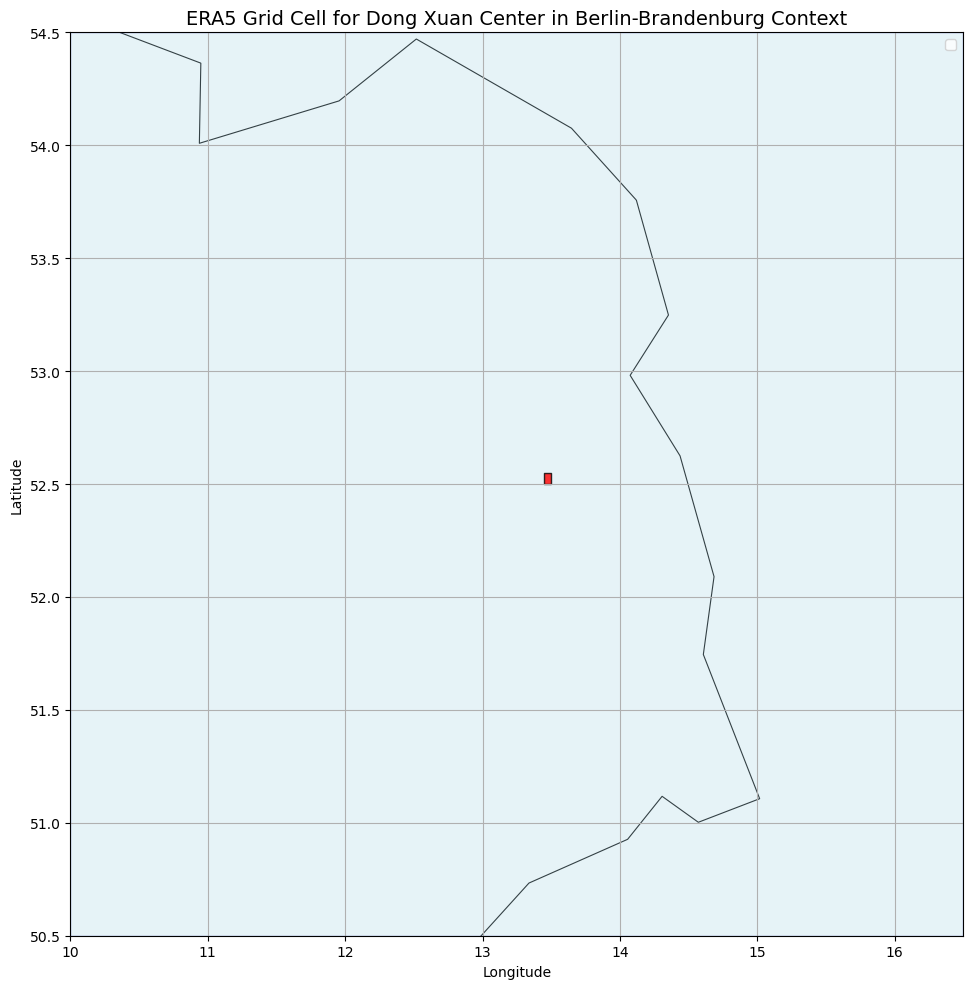

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import math


# 1. Snap Dong Xuan coordinates to ERA5 0.25° grid
def snap_to_grid(coord, resolution=0.25, direction='lower'):
    if direction == 'lower':
        return math.floor(coord / resolution) * resolution
    elif direction == 'upper':
        return math.ceil(coord / resolution) * resolution

lat = 52.5410
lon = 13.4801
minx = snap_to_grid(lon, 0.05, 'lower')   # 13.25
maxx = snap_to_grid(lon, 0.05, 'upper')   # 13.5
miny = snap_to_grid(lat, 0.05, 'lower')   # 52.5
maxy = snap_to_grid(lat, 0.05, 'upper')   # 52.75

# 2. Create the ERA5 grid cell GeoDataFrame for Dong Xuan Center
dongxuan_cell = gpd.GeoDataFrame(
    geometry=[box(minx, miny, maxx, maxy)],
    crs="EPSG:4326"
)

# 3. Load the Germany base map
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
germany = world[world.name == "Germany"]

# 4. Define Berlin/Brandenburg bounding box as GeoDataFrame
bbox_dict = {
    "minx": 10.0,
    "miny": 50.5,
    "maxx": 16.5,
    "maxy": 54.5,
}
bbox_geom = box(bbox_dict["minx"], bbox_dict["miny"], bbox_dict["maxx"], bbox_dict["maxy"])
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_geom], crs="EPSG:4326")

# 5. Plot everything in one figure
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

germany.plot(ax=ax, color='white', edgecolor='black', linewidth=0.8)
bbox_gdf.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.3, label='Berlin-Brandenburg BBox')
dongxuan_cell.plot(ax=ax, color='red', edgecolor='black', alpha=0.8, label='Dong Xuan ERA5 Cell')

# 6. Set extent and styling
ax.set_xlim(bbox_dict["minx"], bbox_dict["maxx"])
ax.set_ylim(bbox_dict["miny"], bbox_dict["maxy"])
ax.set_title("ERA5 Grid Cell for Dong Xuan Center in Berlin-Brandenburg Context", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


### Preparing Atlite Cutout

In [49]:
import atlite
from pathlib import Path
import xarray as xr

# 1. Set folders
output_folder = Path("C:/Users/alex-/Desktop/BatteryStorage/SolarPV_Profile")
tmpdir = Path("C:/Users/alex-/Desktop/BatteryStorage/temp2")
output_folder.mkdir(parents=True, exist_ok=True)

# 2. Bounding box for Dong Xuan Center
x_slice = slice(13.25, 13.5)     # longitude → 13.4801
y_slice = slice(52.5, 52.75)     # latitude  → 52.5410

# 3. Define a single-year cutout with full date range
cutout = atlite.Cutout(
    path=output_folder / "dongxuan_2023_full.nc",
    module="era5",
    x=x_slice,
    y=y_slice,
    time=slice("2023-01-01", "2023-12-31")
)

# 4. Prepare and save
cutout.prepare(
    features=["influx", "temperature"],
    overwrite=True,
    tmpdir=tmpdir
)

print("🎉 Full 2023 cutout successfully created and saved.")


INFO:atlite.cutout:Building new cutout C:\Users\alex-\Desktop\BatteryStorage\SolarPV_Profile\dongxuan_2023_full.nc
INFO:atlite.data:Storing temporary files in C:\Users\alex-\Desktop\BatteryStorage\temp2
INFO:atlite.data:Calculating and writing with module era5:
INFO:atlite.datasets.era5:Requesting data for feature influx...
INFO:atlite.datasets.era5:Requesting data for feature temperature...
c:\Users\alex-\anaconda3\Lib\site-packages\cads_api_client\legacy_api_client.py:101: UserWarning: This is a beta version. The following parameters have not been implemented yet: {'info_callback': <bound method Logger.debug of <Logger atlite.datasets.era5 (INFO)>>}.
  warnings.warn(
2025-07-26 23:37:13,963 WARNING [2025-07-26T21:37:15.940333] You are using a deprecated API endpoint. If you are using cdsapi, please upgrade to the latest version.
2025-07-26 23:37:13,965 INFO Request ID is 61719c43-34d6-45f9-a285-614ecd526a5b
INFO:cads_api_client.processing:Request ID is 61719c43-34d6-45f9-a285-614ecd5

7efd821fffcaa5c583764b05345375d6.nc:   0%|          | 0.00/111k [00:00<?, ?B/s]

c:\Users\alex-\anaconda3\Lib\site-packages\atlite\datasets\era5.py:99: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if "expver" in ds.dims.keys():


KeyError: 'time'

In [40]:
import os
from pathlib import Path

# List all cutouts
cutout_dir = Path("cutouts")
for f in sorted(cutout_dir.glob("germany_2024_*.nc")):
    print("✅ Found:", f)
    cutout_dir

In [41]:
cutout_dir

WindowsPath('cutouts')